# WASP-80b: Wavelength calibration

Hannu Parviainen, Alice Booth, Mantas Abazorius                                                      
hannu.parviainen@physics.ox.ac.uk

Here we compute the pixel-to-wavelength mapping for WASP-80 and the comparison star spectra using the three arc frames (Xe, HgAr, and Ne) taken in the beginning of the night. We assume that the mapping does not change during the night.

**Note:** The FITS headers don't unfortunately contain the arc lamp information, so we have figured the lamps out based on the lines visible in each frame.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from cPickle import dump
from collections import namedtuple
from src.core import *

## Read in the arc frames

In [3]:
Arcs  = namedtuple('arcs', ['ccd1','ccd2'])
arcs1 = Arcs(*[dstack([pf.getdata(arc,i) for arc in l_arc[0]]) for i in range(2)])
arcs2 = Arcs(*[dstack([pf.getdata(arc,i) for arc in l_arc[1]]) for i in range(2)])
arcs  = [arcs1,arcs2]

## Create a linelist dataframe

In [4]:
lcenters, lnames = [], []
with open('data/spec_linelist.txt','r') as f:
    for l in f.readlines():
        ls = l.split()
        lcenters.append(float(ls[1])*1e-1)
        lnames.append(ls[3])

lines = pd.DataFrame(lnames, columns=['element'])
lines['center'] = lcenters

lines_xe   = array(lines[lines.element=='XeI'].center)
lines_hgar = array(lines[(lines.element=='HgI') | (lines.element=='ArI')].center)
lines_ne   = array(lines[lines.element=='NeI'].center)

## Plot the arc frames 

In [5]:
jul16 = pd.read_hdf('data/aux.h5','jul16')
aug25 = pd.read_hdf('data/aux.h5','aug25')

In [6]:
centers = array([df[['center_1','center_2']].median().values for df in [jul16,aug25]]).mean(0).round().astype(np.int)
ymins, ymaxs = centers.astype(np.int)-15, centers.astype(np.int)+15

In [7]:
sl1, sl2 = [s_[c-15:c+15] for c in centers]

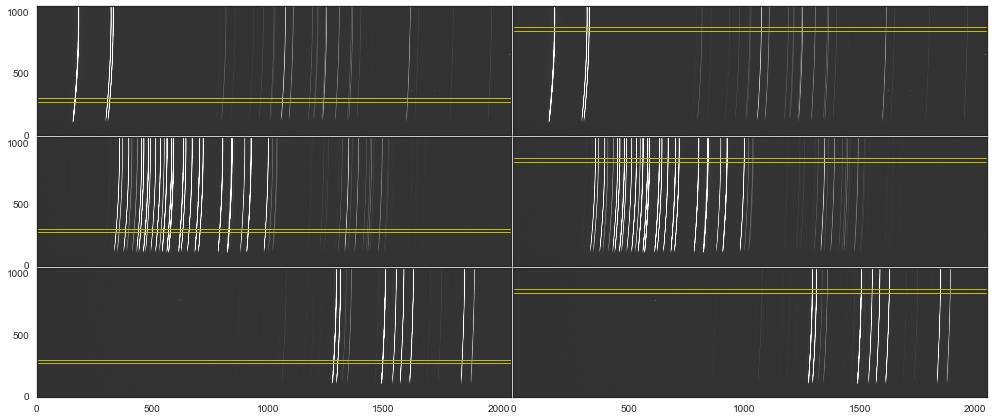

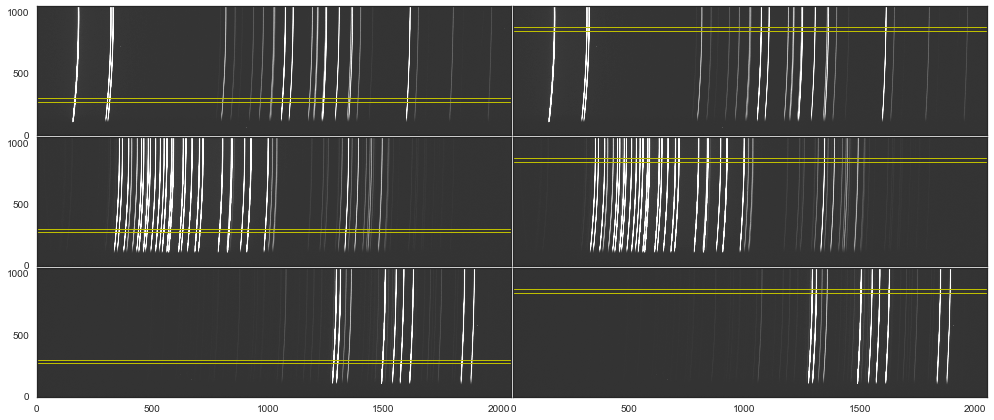

In [8]:
imargs = dict(aspect='auto', origin='image', cmap=cm.gray, vmin=500, vmax=4000)
for irun,ar in enumerate(arcs):
    fig,axs = subplots(3,2,figsize=(14,6),sharex=True)
    for i in range(3):
        axs[i,0].imshow(ar.ccd1[:,:,i].T, **imargs)
        axs[i,1].imshow(ar.ccd2[:,:,i].T, **imargs)
        axs[i,0].axhspan(ymins[0],ymaxs[0], color='y', fill=False, lw=1)
        axs[i,1].axhspan(ymins[1],ymaxs[1], color='y', fill=False, lw=1)
    setp(axs[:,1], yticks=[])
    setp(axs, ylim=(0,ar.ccd1.shape[1]))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.005, hspace=0.015)

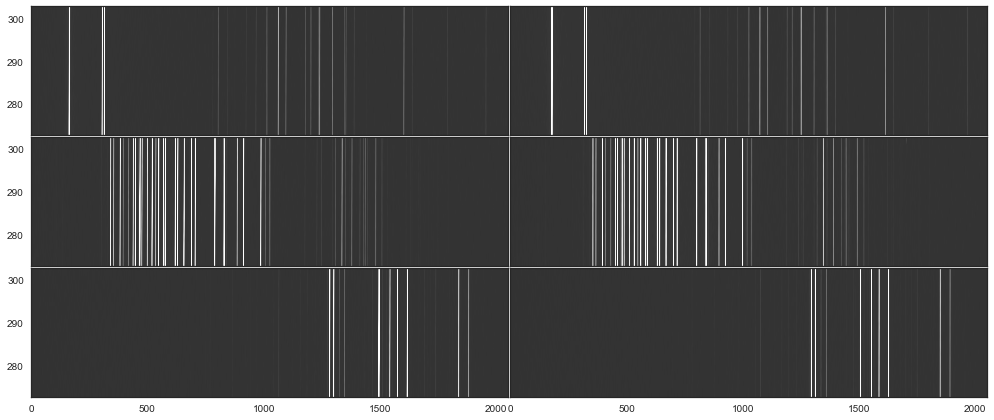

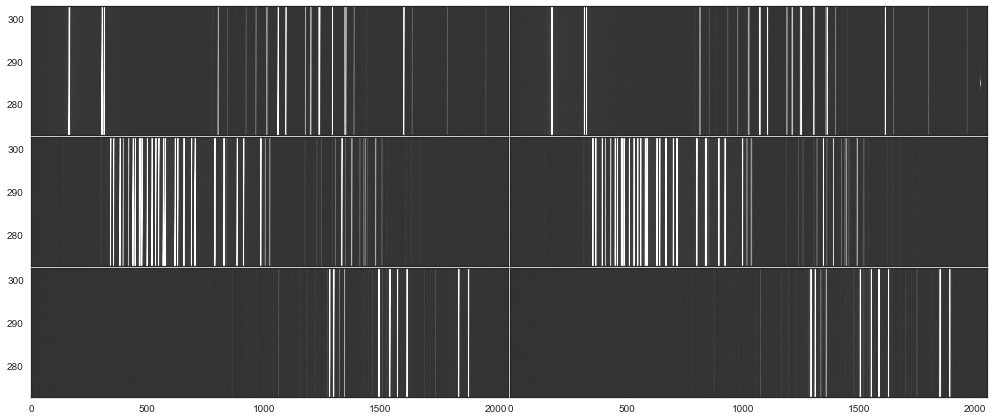

In [9]:
imargs = dict(aspect='auto', origin='image', cmap=cm.gray, vmin=500, vmax=4000)
for irun,ar in enumerate(arcs):
    fig,axs = subplots(3,2,figsize=(14,6),sharex=True)
    for i in range(3):
        axs[i,0].imshow(ar.ccd1[:,:,i].T, **imargs)
        axs[i,1].imshow(ar.ccd2[:,:,i].T, **imargs)
        axs[i,0].set_ylim(ymins[0],ymaxs[0])
        axs[i,1].set_ylim(ymins[1],ymaxs[1])
    setp(axs[:,1], yticks=[])
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.005, hspace=0.015)

/home/hannu/.local/lib/python2.7/site-packages/matplotlib-1.5.0_836.g4d81e2c-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family [u'DejaVu Sans Display'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


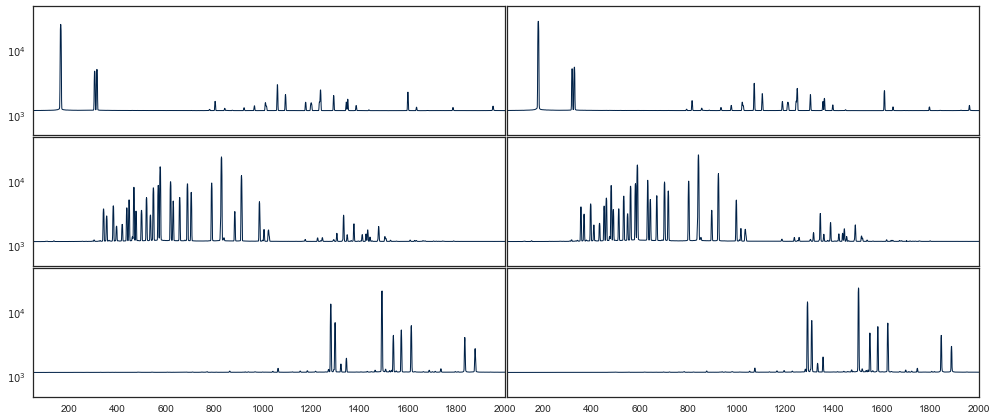

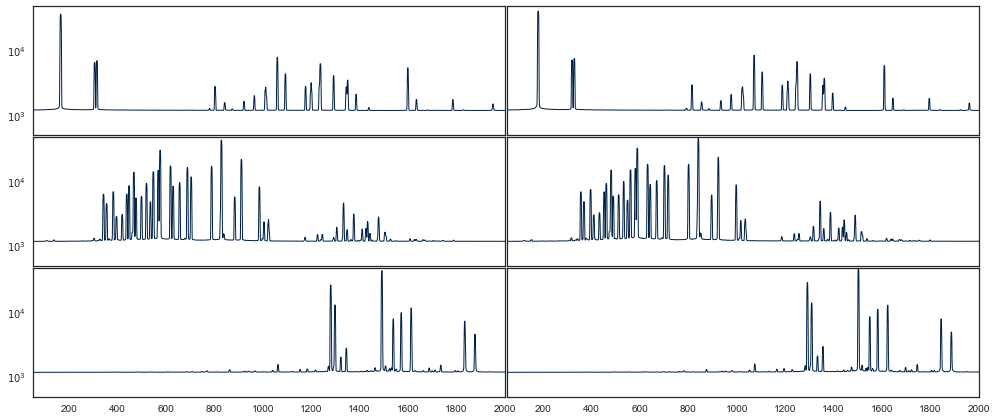

In [10]:
for ar in arcs:
    fig,axs = subplots(3,2,figsize=(14,6),sharex=True, sharey=True)
    for i in range(3):
        axs[i,0].semilogy(ar.ccd1[:,sl1,i].mean(1), lw=1)
        axs[i,1].semilogy(ar.ccd2[:,sl2,i].mean(1), lw=1)
    setp(axs, xlim=(50,2000), ylim=(500,51000))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.005, hspace=0.015)

## Spectral line fitting

In [11]:
%run src/core.py

def subtract_median(a):
    return a-median(a)

class CCDFitter(object):
    def __init__(self, arc, sl, ccd=1):
        self.spectrum_xe   = subtract_median(arc[:,sl,2].mean(1))
        self.spectrum_hgar = subtract_median(arc[:,sl,0].mean(1))
        self.spectrum_ne   = subtract_median(arc[:,sl,1].mean(1))

        if ccd == 1:
            cs_xe = CalibrationSpectrum('XeI', self.spectrum_xe, lines_xe, 
                                [7, 1280, 4.7e4,  1299, 2.0e4,  1490, 6.0e4,  1540, 1.0e4,
                                    1575, 1.5e4,  1620, 1.5e4,  1840, 1.0e4,  1878, 0.5e4])
        elif ccd == 2:
            cs_xe = CalibrationSpectrum('XeI', self.spectrum_xe, lines_xe, 
                                [7, 1280, 4.7e4,  1299, 2.0e4,  1490, 6.0e4,  1540, 1.0e4,
                                    1575, 1.5e4,  1615, 1.5e4,  1835, 1.0e4,  1873, 0.5e4])
            
        cs_hgar = CalibrationSpectrum('HgAr', self.spectrum_hgar, lines_hgar, 
                            [7,  165, 4.0e4,   305, 1.0e4,   315, 1.0e4,  1055, 2.0e4, 
                                1090, 1.0e4,  1235, 1.5e4])

        cs_ne1 = CalibrationSpectrum('NeI1', self.spectrum_ne, lines_ne[:12], 
                            [7, 341, 6.0e3,  353, 5.0e3,  381, 7.0e3, 395, 3.0e3,
                                418, 3.0e3,  437, 1.0e4,  446, 1.0e4, 466, 1.0e4,
                                475, 1.0e4,  497, 5.0e3,  518, 1.0e4, 534, 5.0e3])

        cs_ne2 = CalibrationSpectrum('NeI2', self.spectrum_ne, lines_ne[12:20], 
                            [7, 546, 1.5e4,  566, 2.0e4,  575,  4.0e4,  617, 2.5e4,
                                628, 1.0e4,  655, 1.0e4,  687,  2.0e4,  702, 2.0e4])
      
        cs_ne3 = CalibrationSpectrum('NeI3', self.spectrum_ne, lines_ne[20:25], 
                            [7, 789, 1.5e4, 829, 1e4, 885, 1e4, 912, 1e4, 986, 5e3])    

        self.wlf = WLFitter([cs_xe, cs_hgar, cs_ne1, cs_ne2, cs_ne3])
        
        
    def fit(self, offset=0):
        self.wlf.fit(offset=offset)

## July 19

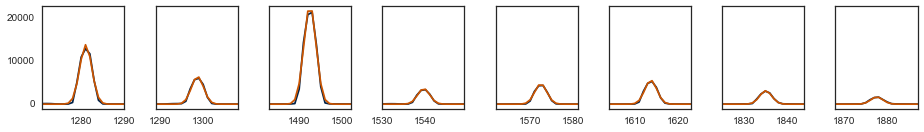

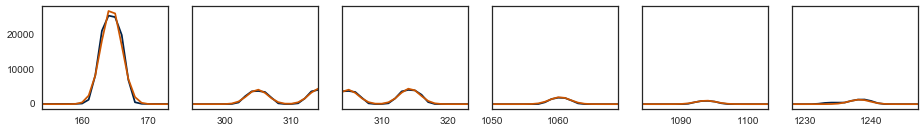

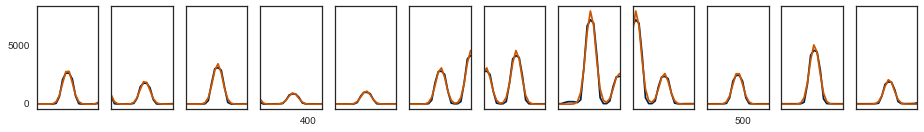

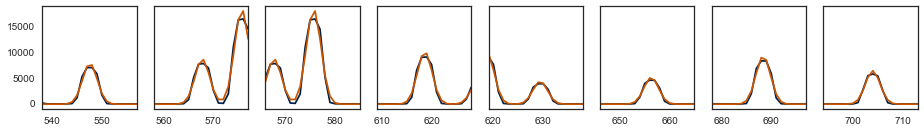

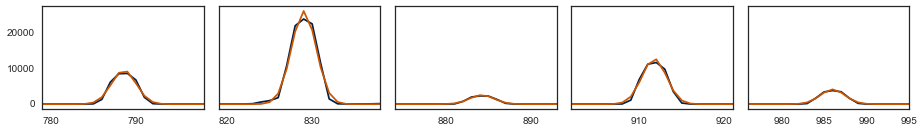

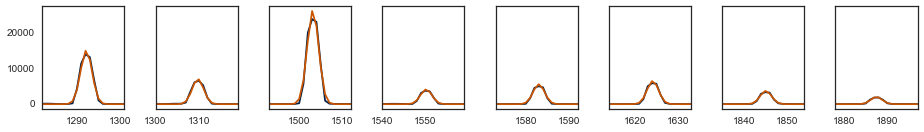

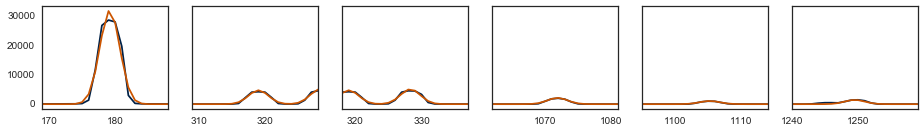

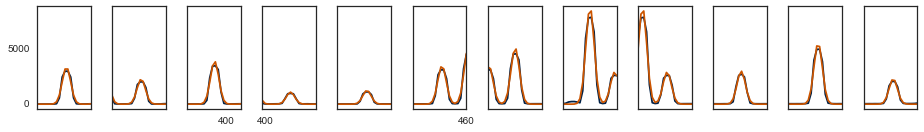

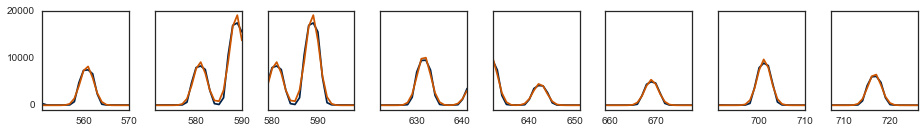

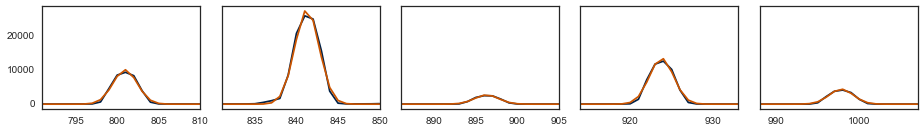

In [13]:
n1ccd1f = CCDFitter(arcs1.ccd1, sl1, ccd=1)
n1ccd2f = CCDFitter(arcs1.ccd2, sl2, ccd=2)

n1ccd1f.fit()
n1ccd2f.fit(offset=11)

[s.plot() for s in n1ccd1f.wlf.spectra];
[s.plot() for s in n1ccd2f.wlf.spectra];

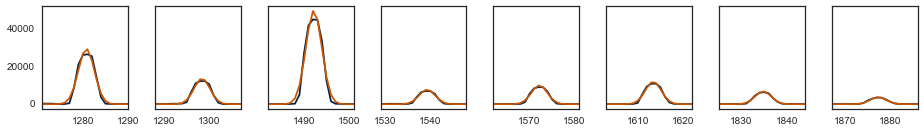

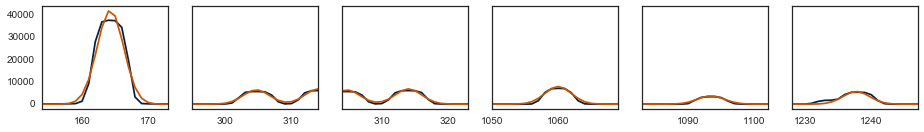

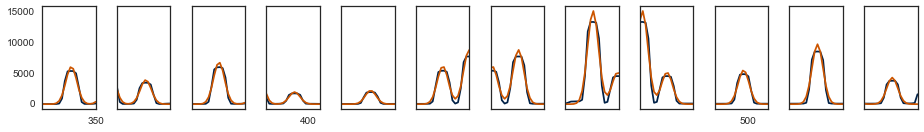

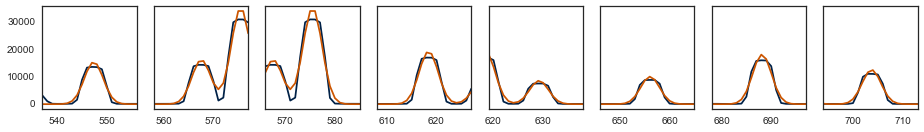

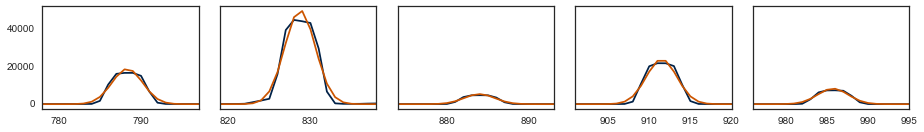

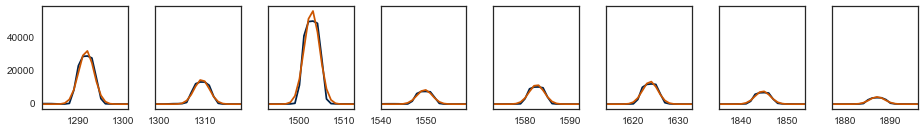

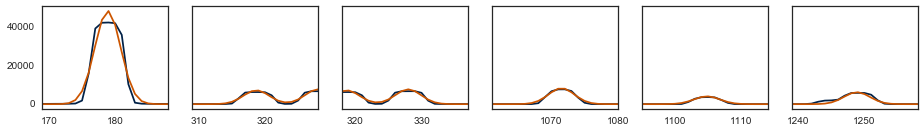

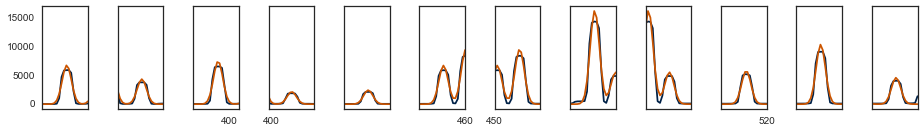

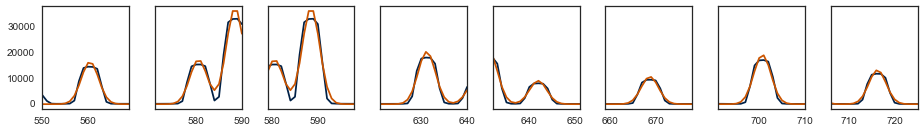

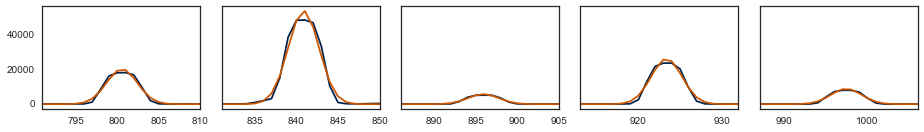

In [14]:
n2ccd1f = CCDFitter(arcs2.ccd1, sl1, ccd=1)
n2ccd2f = CCDFitter(arcs2.ccd2, sl2, ccd=2)

n2ccd1f.fit(offset=-2)
n2ccd2f.fit(offset=13)

[s.plot() for s in n2ccd1f.wlf.spectra];
[s.plot() for s in n2ccd2f.wlf.spectra];

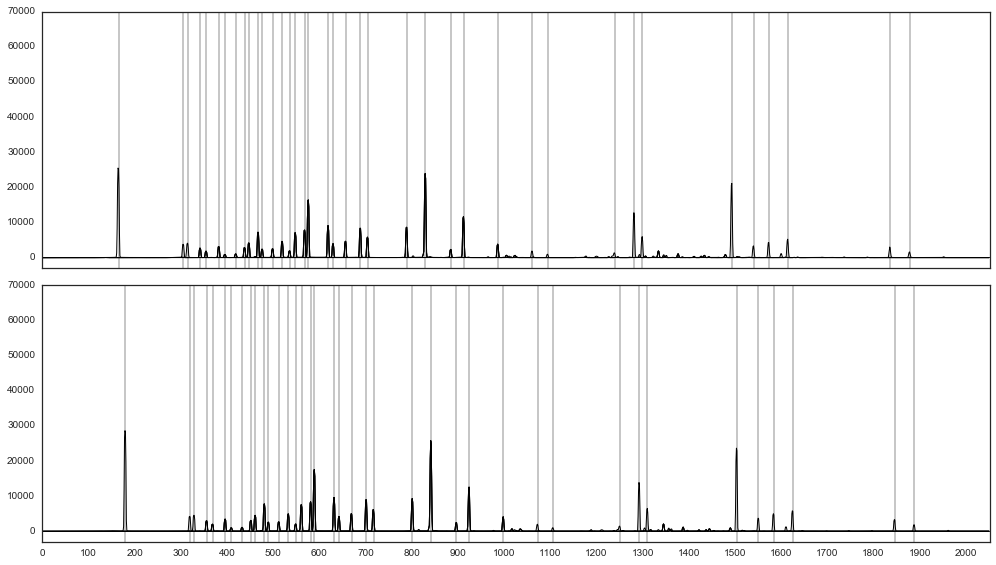

In [15]:
fig,ax = subplots(2,1,figsize=(14,8), sharex=True)
for iax, ccd in enumerate([n1ccd1f,n1ccd2f]):
    [ax[iax].axvline(l, c='k', alpha=0.25, ymax=1) for l in ccd.wlf.wl_to_pixel(ccd.wlf.lines)]
    [ax[iax].plot(s.spectrum, c='k', lw=1) for s in ccd.wlf.spectra]
setp(ax, xlim=(0, ccd.wlf.spectra[0].spectrum.size), ylim=(-3e3,7e4))
fig.tight_layout()

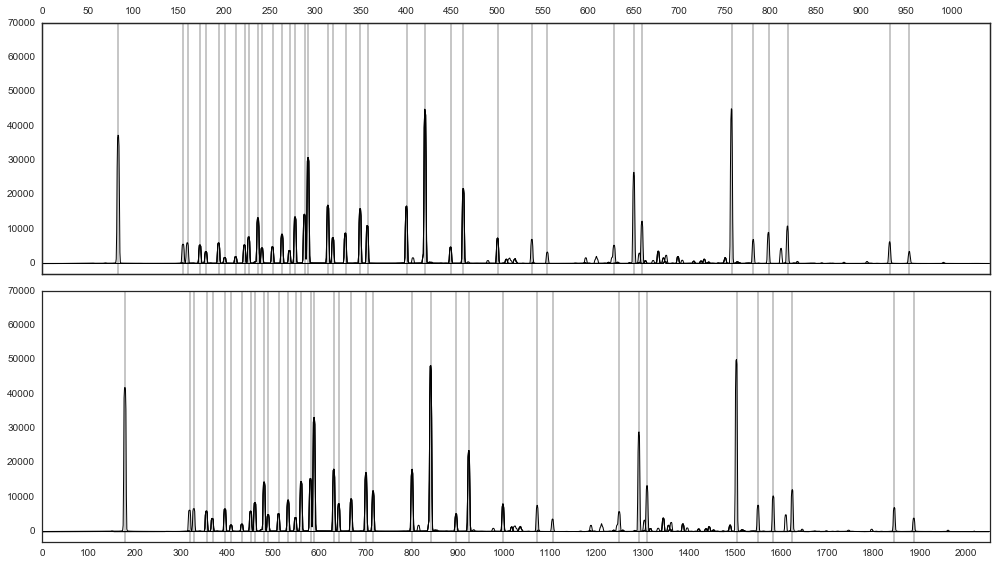

In [16]:
fig,ax = subplots(2,1,figsize=(14,8), sharex=True)
for iax, ccd in enumerate([n2ccd1f,n2ccd2f]):
    [ax[iax].axvline(l, c='k', alpha=0.25, ymax=1) for l in ccd.wlf.wl_to_pixel(ccd.wlf.lines)]
    [ax[iax].plot(s.spectrum, c='k', lw=1) for s in ccd.wlf.spectra]
awl = ax[0].twiny()
setp(awl, xlim=(0,1041.20891543))
#setp(awl, xlim=n2ccd2f.wlf.pixel_to_wl([0,ccd.wlf.spectra[0].spectrum.size]))
setp(ax, xlim=(0, ccd.wlf.spectra[0].spectrum.size), ylim=(-3e3,7e4))
fig.tight_layout()

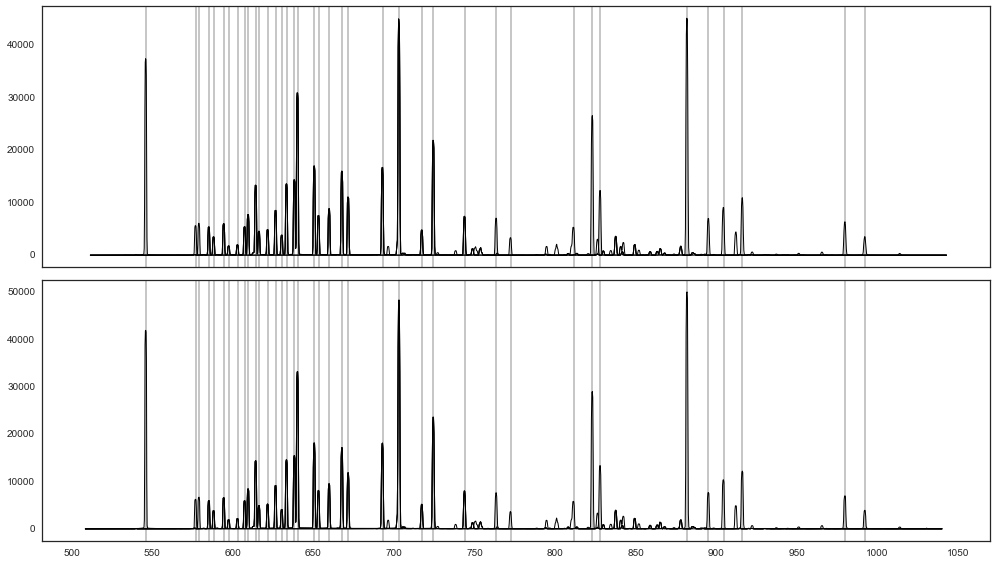

In [17]:
fig,ax = subplots(2,1,figsize=(14,8), sharex=True)
for iax, ccd in enumerate([n2ccd1f,n2ccd2f]):
    x = ccd.wlf.pixel_to_wl(arange(ccd.wlf.spectra[0].spectrum.size))
    [ax[iax].axvline(l, c='k', alpha=0.25, ymax=1) for l in ccd.wlf.lines]
    [ax[iax].plot(x, s.spectrum, c='k', lw=1) for s in ccd.wlf.spectra]
#setp(ax, xlim=(0, ccd.wlf.spectra[0].spectrum.size), ylim=(-3e3,7e4))
fig.tight_layout()

In [18]:
with open('results/wl_calibration.pkl', 'w') as f:
    dump(dict(n1ccd1=n1ccd1f.wlf.solution,
              n1ccd2=n1ccd2f.wlf.solution,
              n2ccd1=n2ccd1f.wlf.solution,
              n2ccd2=n2ccd2f.wlf.solution), f)

---

<center> &copy; 2016 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>